# Regression Analysis

In [1]:
# special Jupyter Notebook command to prepare the notebook for matplotlib and other libraries
%matplotlib notebook

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-colorblind')

from statsmodels.formula.api import ols

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("darkgrid")
sns.set_context("notebook")

In [2]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', index_col=False)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 15 columns):
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(1), object(6)
memory usage: 17.5+ MB


## Does injured pay replace regular earnings?

In the general data visualizations notebook a possible correlation between ***regular*** and ***injured*** earnings categories. 

2017 number of employees: 1278


<IPython.core.display.Javascript object>


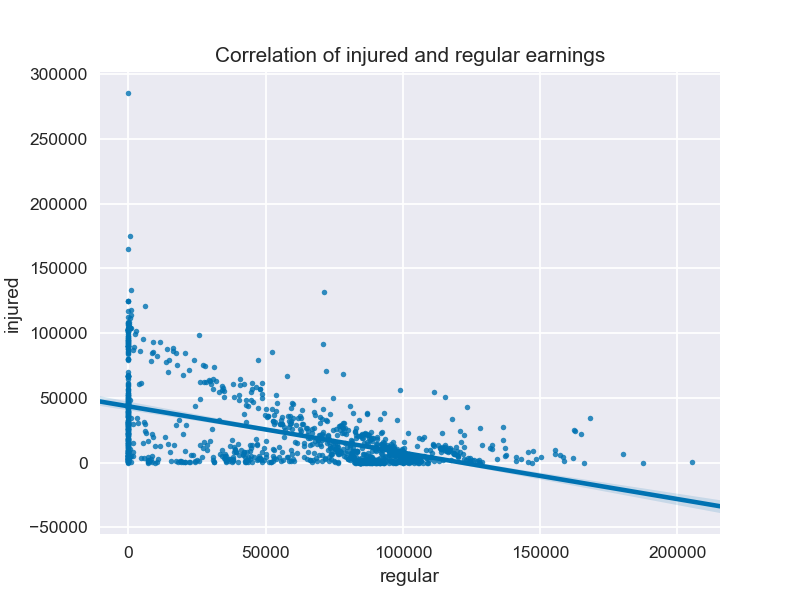

In [17]:
""" 
All 2017 data with more than $1 injured pay
"""
injured = earnings[(earnings.injured > 1) & (earnings.year == 2017)]

print('2017 number of employees:', injured.shape[0])
plt.figure()
g1 = sns.regplot(x='regular', y='injured', data=injured, scatter_kws={'s':10})
g1.set_title('Correlation of injured and regular earnings')
plt.show()

Some adjustments to the data are necessary since the database captures "earnings" and not salaries. The data is arbitrarily limited to combined injured pay and regular earnings of at least $50,000. Additionally we are interested in long-term injured pay of at least $5,000 for the year 2017.

2017 number of employees: 608


<IPython.core.display.Javascript object>


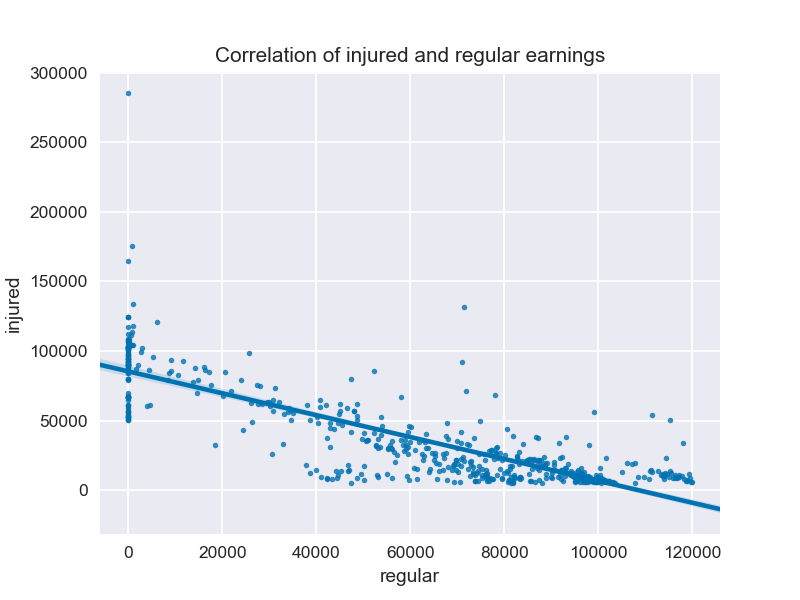

In [16]:
""" 
dataset focused on 'normal' income levels with both regular and injured earnings types
"""
injured = earnings[((earnings.injured + earnings.regular) > 50000) \
                   & (earnings.regular < 120000) \
                   & (earnings.injured > 5000) \
                   & (earnings.year == 2017)]\
                    [['regular', 'injured']]

print('2017 number of employees:', injured.shape[0])
plt.figure()
g2 = sns.regplot(x='regular', y='injured', data=injured, scatter_kws={'s':10})
g2.set_title('Correlation of injured and regular earnings')
plt.show()

In [5]:
m = ols('regular ~ injured', injured).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                regular   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     1495.
Date:                Sat, 19 May 2018   Prob (F-statistic):          9.10e-166
Time:                        17:02:11   Log-Likelihood:                -6898.6
No. Observations:                 608   AIC:                         1.380e+04
Df Residuals:                     606   BIC:                         1.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.476e+04   1203.494     78.736      0.0

Once the earnings data is modified to correct for part time employment and *"minor injuries"*, i.e. injured pay (less than $5,000), the data shows some correlation which could be explained by injured pay replacing regular earnings. According to the OLS model, for every dollar lost in regular earnings, the employee receives about 90 cents injured pay. The correlation is rather weak. Only ~ 70% of the variance is explained by the model.

____

## Can we quantify geographic wealth segregation?

In the general visualizations notebook, a map of the higher earning employees vs. the lower earning employees showed clear segregation. 

Zillow's median home values by zip code ("Zhvi") can be compared to Boston employee median earnings.

In an attempt to filter part time employees, an arbitrary minimum regular earnings is set at $30,000.

<IPython.core.display.Javascript object>


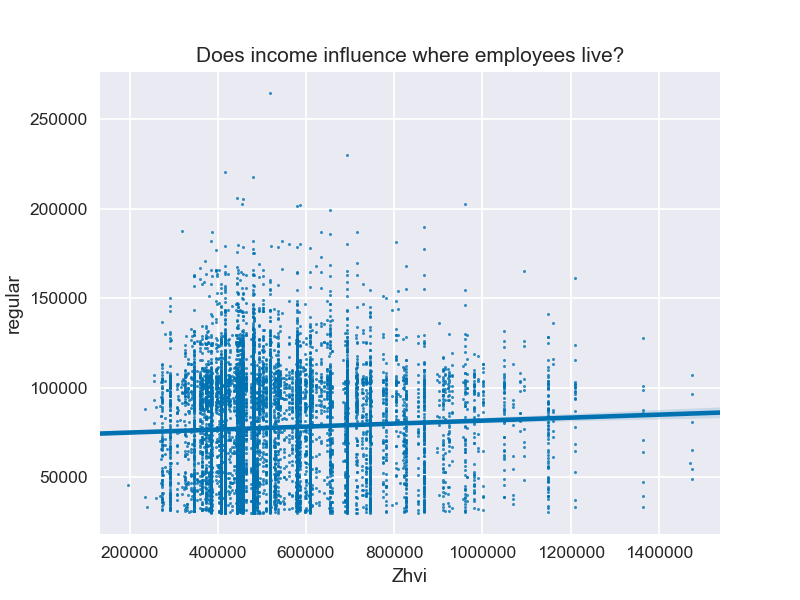

In [20]:
"""
Zillow provides a home value estimator by zip code called the "Zhvi" or Zillow home value index:
*A smoothed, seasonally adjusted measure of the median estimated home value across a given region and housing type.*

https://www.zillow.com/research/data/

The data used is the zip code data set from April 2018.
"RegionName" = zip code
"""
# Zillow home values:
home_values = pd.read_csv('Zip_Zhvi_Summary_AllHomes.csv', dtype={'RegionName': object})
home_values = home_values[(home_values.Metro == 'Boston')][['RegionName', 'Zhvi']]

# regular earnings by zip code data frame:
e_by_zip = earnings[(earnings.zip.isin(home_values['RegionName'])) & (earnings.year == 2017) & (earnings['regular'] > 30000)]\
                .merge(home_values, how='left', left_on='zip', right_on='RegionName')[['regular', 'zip', 'Zhvi']]
    
# regression plot of regular earnings by home values
plt.figure()
g3 = sns.regplot(x='Zhvi', y='regular', data=e_by_zip, scatter_kws={'s':3})
g3.set_title('Does income influence where employees live?')
plt.show()

In [7]:
reg = ols('Zhvi ~ regular',e_by_zip).fit()
print(reg.summary())


                            OLS Regression Results                            
Dep. Variable:                   Zhvi   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     30.28
Date:                Sat, 19 May 2018   Prob (F-statistic):           3.80e-08
Time:                        17:02:11   Log-Likelihood:            -2.0757e+05
No. Observations:               15584   AIC:                         4.151e+05
Df Residuals:                   15582   BIC:                         4.152e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.071e+05   3486.512    145.441      0.0

The OLS model suggests there is a very modest correlation between regular earnings of an employee and the Zillow home value index of the employee's home zip code. For every $10,000 in regular earnings, the Zillow home value index will increase by approximately $2225, on average for all zip codes and employees making at least $30000 in 2017. In practice there is hardly any value in such a weak correlation. There are many factors that mitigate wealth segregation such as

* subsidized housing
* family ties
* personal history
* individual financial constraints

That said, there are definitely some extreme cases that can be highlighted:

   neighborhood    Zhvi
9        Milton  653795
10   Roslindale  518379
75      Roxbury  385426


<IPython.core.display.Javascript object>


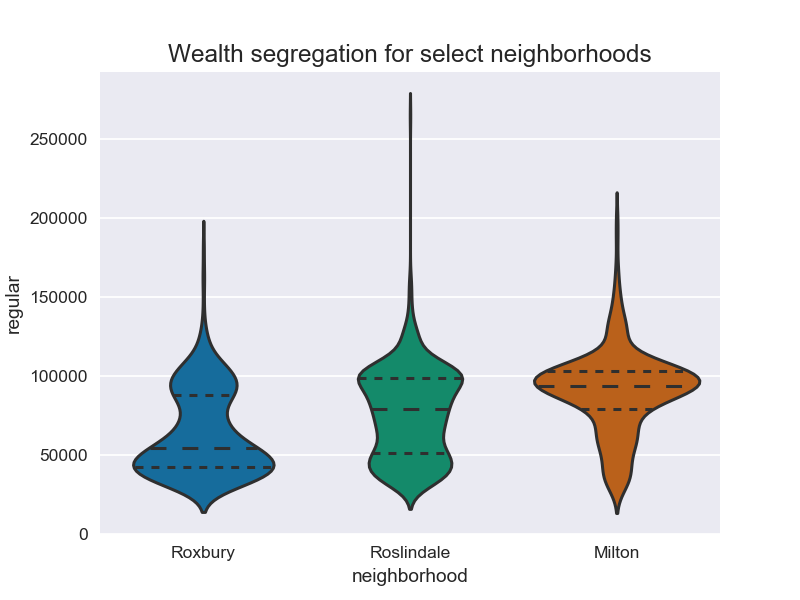

In [19]:
# example neighborhoods:
neighborhoods = pd.DataFrame.from_dict({'02186': 'Milton', '02131': 'Roslindale', '02121': 'Roxbury'}, orient='index')\
                            .reset_index()
neighborhoods.columns = ['nzip', 'neighborhood']

# add neighborhood names to data frame:
e_by_zip = e_by_zip.merge(neighborhoods, how='left', left_on='zip', right_on='nzip')                          
seg = e_by_zip[(e_by_zip.zip.isin(neighborhoods.nzip))]
print(seg[['neighborhood', 'Zhvi']].drop_duplicates())

# plot regular income violin plots for exampmle neighborhoods:
plt.figure()
g4 = sns.violinplot(x='neighborhood', y='regular', data=seg, order=['Roxbury', 'Roslindale', 'Milton'], inner='quartile')
g4.set_title('Wealth segregation for select neighborhoods', fontsize=14)
plt.show()

The shape of the violinplots above should be no surprise to local Bostonians. Roxbury is as undesirable as Milton is desirable a neighborhood. The plots show predominantly low income employees in Roxbury with only a few employees earning more than $100,000 in 2017. The median regular earnings are less than $50,000. Milton's employees earn a median of close to $100,000 and a first quartile already above Roxbury's median. Roslindale is a diverse neighborhood with a near cylindrical-shaped violin plot.